# Logistic Regression with a Neural Network mindset

Welcome to your first (required) programming assignment! You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [3]:
def load_dataset():
    with h5py.File('train_catvnoncat.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File('test_catvnoncat.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [4]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

y = [1], it's a 'cat' picture.


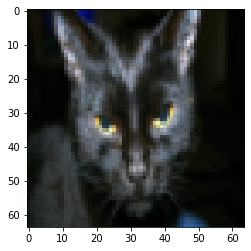

In [5]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") +  "' picture.")

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [7]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [8]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [9]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<font color='blue'>
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b)$ to make predictions.

In [42]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [43]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


**Expected Output**: 

<table style="width:20%">
  <tr>
    <td>**sigmoid(0)**</td>
    <td> 0.5</td> 
  </tr>
  
  <tr>
    <td>**sigmoid(9.2)**</td>
    <td> 0.999898970806 </td> 
  </tr>
</table>

### 4.2 - Initializing parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [44]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w, b = np.zeros((dim,1)), 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [45]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [46]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b) 
    cost = -1./m* np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1./m*np.dot(X, (A-Y).T)
    db = 1./m*np.sum(A-Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [47]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
        <td> [[ 0.99993216]
 [ 1.99980262]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.499935230625 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 6.000064773192205</td>
    </tr>

</table>

### d) Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [48]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [49]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


**Expected Output**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.1124579 ]
 [ 0.23106775]] </td>
    </tr>
    
    <tr>
       <td> **b** </td>
       <td> 1.55930492484 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.90158428]
 [ 1.76250842]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.430462071679 </td>
    </tr>

</table>

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There is two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [50]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) +b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0,i] = 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [51]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [56]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [57]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Expected Output**: 

<table style="width:40%"> 
    
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test error is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

y = 1, you predicted that it is a "cat" picture.


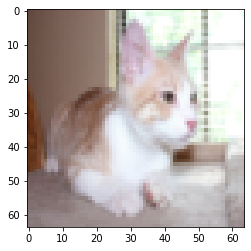

In [62]:
# Example of a picture that was wrongly classified.
index = 4
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0, index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0, index])].decode("utf-8") +  "\" picture.")


Let's also plot the cost function and the gradients.

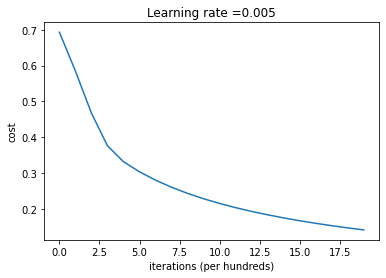

In [59]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c